In [130]:
from pprint import pprint


import matplotlib.pyplot as plt

import numpy as np


import hoho
from hoho import compute_WED
from hoho import vis
from hoho.vis import line

from scipy.spatial.distance import cdist
import cv2
hoho.LOCAL_DATADIR = hoho.setup("../data")
from handcrafted_solution import predict
from tqdm import tqdm
import trimesh
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
import scipy.interpolate as si

Using ..\data as the data directory (we are running locally)


In [131]:
split = "all"
samples = []
for i, sample in tqdm(enumerate(hoho.get_dataset(decode=None, split=split))):
    if i > 10:
        break
    samples.append((hoho.decode(sample)))


11it [00:03,  3.59it/s]


In [132]:
sample = samples[0]

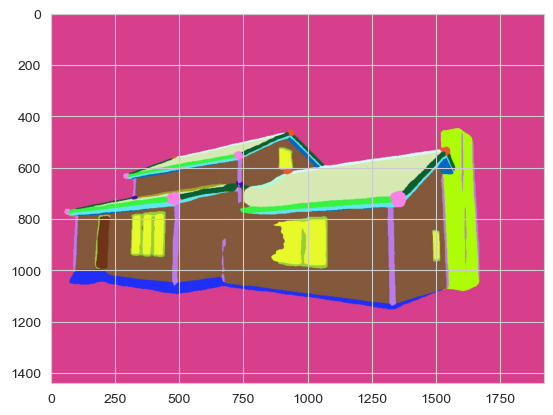

In [133]:
plt.imshow(sample["gestalt"][0])

In [137]:
from handcrafted_solution import clean_points3d, get_depthmap_from_pointcloud

In [331]:
sample = samples[0]

In [332]:
points3d_kdtree, biggest_cluster_keys, image_dict = clean_points3d(sample, 120)

In [333]:
depthmap = np.array(sample["depthcm"][0])

In [334]:
K, R, t = sample['K'][0], sample['R'][0], sample['t'][0]
imagekey = sample["__imagekey__"][0]
image = image_dict[imagekey]

In [335]:
projected2d, depth = get_depthmap_from_pointcloud(image, sample["points3d"], biggest_cluster_keys, R, t)

In [339]:
projected2d = projected2d.astype(np.int32)

In [340]:
# pointcloud_deptmap[projected2d[:, 1], projected2d[:, 0]] = depth

In [348]:
pointcloud_deptmap = np.full_like(depthmap, 4000)

for point, depth_value in zip(projected2d, depth):
    cv2.circle(pointcloud_deptmap, point, 20, depth_value, -1)
# cv2.circle(pointcloud_deptmap, (projected2d[0, 0], projected2d[0, 1]), 5, depth, -1)

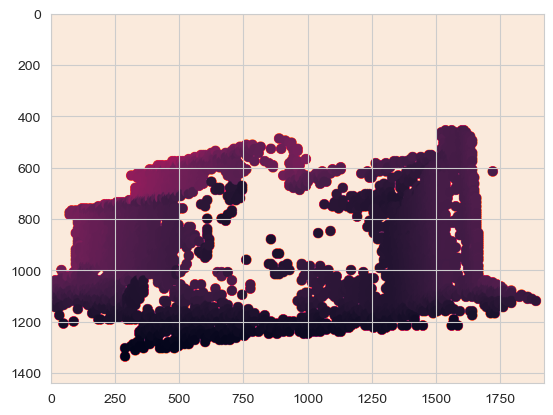

In [349]:
plt.imshow(pointcloud_deptmap)

In [560]:
import trimesh
mesh = trimesh.Trimesh(vertices=sample["mesh_vertices"], faces=sample["mesh_faces"][:,1:], use_embree=True)

In [561]:
world_to_cam = np.eye(4)
world_to_cam[:3, :3] = R
world_to_cam[:3, 3] = t
camera_transform = np.linalg.inv(world_to_cam)

In [562]:

camera = trimesh.scene.Camera(focal=(K[0, 0], K[1, 1]), resolution=depthmap.shape[::-1])
scene = trimesh.scene.scene.Scene(camera=camera, camera_transform=camera_transform)
pointcloud = trimesh.points.PointCloud(
    vertices=[point3D.xyz for point_id, point3D in sample["points3d"].items()],
    colors=[point3D.rgb for point_id, point3D in sample["points3d"].items()])
scene.add_geometry(pointcloud)
# [scene.add_geometry(i) for i in hoho.vis.show_wf(predicted_wf, 2)]
# scene.show()
scene.add_geometry(mesh)
[scene.add_geometry(i) for i in hoho.vis.show_wf(sample, 2)]
scene.show()

In [151]:
ray_origins, ray_directions, corresponding_pixels = scene.camera_rays()

In [152]:

intersections = mesh.ray.intersects_location(ray_origins, -ray_directions, multiple_hits=False)

In [153]:
# help(trimesh.ray.ray_pyembree)

In [154]:
locations, index_ray, index_tri = intersections

In [155]:
len(np.unique(index_ray)), len(index_ray)

(823645, 823645)

In [156]:
mesh_depths = np.linalg.norm(ray_origins[index_ray] - locations, axis=1)

In [284]:
mesh_depthmap = np.full(camera.resolution, 4000)
mesh_depthmap[corresponding_pixels[index_ray, 0], corresponding_pixels[index_ray, 1]] = mesh_depths
mesh_depthmap = cv2.flip(cv2.rotate(mesh_depthmap, cv2.ROTATE_90_COUNTERCLOCKWISE), 1)

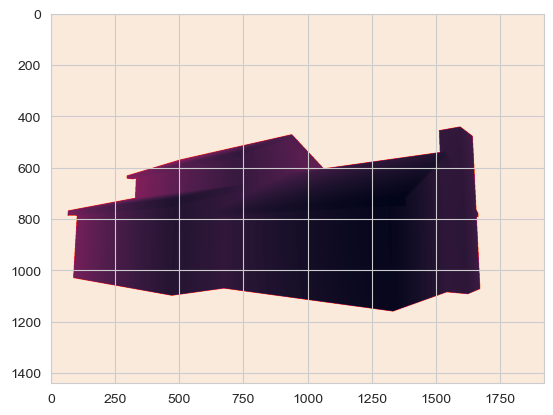

In [285]:
plt.imshow(mesh_depthmap)

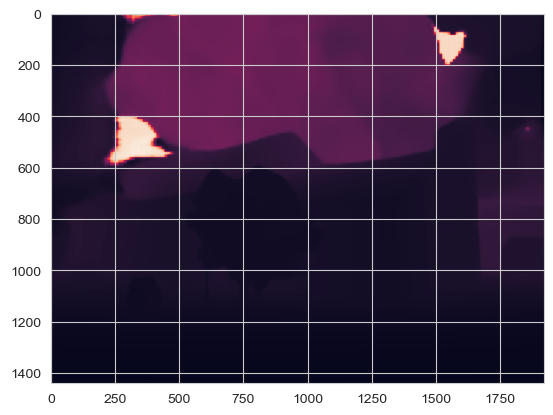

In [201]:
plt.imshow(depthmap)

In [541]:
import torch
from torch import nn
import torchvision as tv
class DepthMerger(nn.Module):
    def __init__(self):
        super(DepthMerger, self).__init__()
        # depthmap is a 1 channel image
        self.depthmap_encoder = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3),
            # nn.AvgPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(3, 3, kernel_size=3),
        )
        self.pointcloud_encoder = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3),
            # nn.AvgPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(3, 3, kernel_size=3),
        )


        self.depth_concatenator = lambda *x: torch.hstack(x)

        self.decoder = nn.Sequential(
            nn.Conv2d(6, 3, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(3, 3, kernel_size=3, stride=1),
            nn.ReLU(),


            nn.ConvTranspose2d(3, 3, kernel_size=3),
            nn.ReLU(),
            # nn.UpsamplingNearest2d(scale_factor=2),
            
            nn.ConvTranspose2d(3, 1, kernel_size=3),
            nn.ReLU(),
        )

        # self.model = tv.models.segmentation.deeplabv3_resnet50(pretrained=True)
        # self.model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    def forward(self, depthmap, pointcloud):
        depthmap = self.depthmap_encoder(depthmap)
        pointcloud = self.pointcloud_encoder(pointcloud)
        x = self.depth_concatenator(depthmap, pointcloud)
        return self.decoder(x)
from torchsummary import summary
model = DepthMerger().cuda()
summary(model, [(1, 480, 640), (1, 480, 640)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 478, 638]              30
              ReLU-2          [-1, 3, 478, 638]               0
            Conv2d-3          [-1, 3, 476, 636]              84
            Conv2d-4          [-1, 3, 478, 638]              30
              ReLU-5          [-1, 3, 478, 638]               0
            Conv2d-6          [-1, 3, 476, 636]              84
            Conv2d-7          [-1, 3, 474, 634]             165
              ReLU-8          [-1, 3, 474, 634]               0
   ConvTranspose2d-9          [-1, 3, 476, 636]              84
             ReLU-10          [-1, 3, 476, 636]               0
  ConvTranspose2d-11          [-1, 3, 478, 638]              84
             ReLU-12          [-1, 3, 478, 638]               0
  ConvTranspose2d-13          [-1, 1, 480, 640]              28
             ReLU-14          [-1, 1, 4

In [434]:
def get_mesh_depthmap(mesh, K, R, t, depthmap, fill_value=4000):
    
    world_to_cam = np.eye(4)
    world_to_cam[:3, :3] = R
    world_to_cam[:3, 3] = t
    camera_transform = np.linalg.inv(world_to_cam)
    camera = trimesh.scene.Camera(focal=(K[0, 0], K[1, 1]), resolution=depthmap.shape[::-1])
    scene = trimesh.scene.scene.Scene(camera=camera, camera_transform=camera_transform)
    ray_origins, ray_directions, corresponding_pixels = scene.camera_rays()
    locations, index_ray, index_tri = mesh.ray.intersects_location(ray_origins, -ray_directions, multiple_hits=False)
    mesh_depths = np.linalg.norm(ray_origins[index_ray] - locations, axis=1)
    mesh_depthmap = np.full(camera.resolution, fill_value)
    mesh_depthmap[corresponding_pixels[index_ray, 0], corresponding_pixels[index_ray, 1]] = mesh_depths
    mesh_depthmap = cv2.flip(cv2.rotate(mesh_depthmap, cv2.ROTATE_90_COUNTERCLOCKWISE), 1)
    return mesh_depthmap

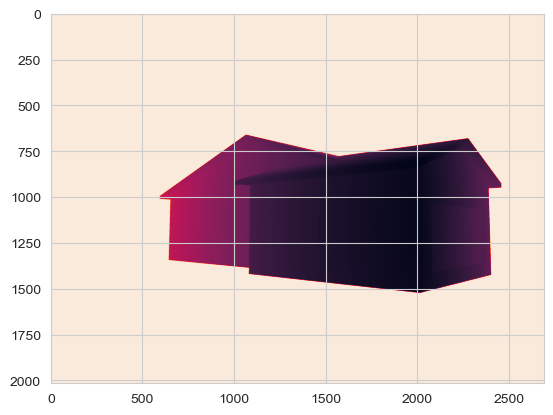

In [408]:
plt.imshow(get_mesh_depthmap(mesh, K, R, t, depthmap))

In [ ]:
split = "all"
samples = []
for i, sample in tqdm(enumerate(hoho.get_dataset(decode=None, split=split))):
    if i > 20:
        break
    samples.append((hoho.decode(sample)))


In [537]:

precomputed_depthmaps = {}
for i, sample in tqdm(enumerate(samples)):
    points3d_kdtree, biggest_cluster_keys, image_dict = clean_points3d(sample, 120)
    mesh = trimesh.Trimesh(vertices=sample["mesh_vertices"], faces=sample["mesh_faces"][:,1:], use_embree=True)
    for j in range(len(sample["K"])):
        
        depthmap = np.array(sample["depthcm"][j]) / 2.54
        fill_value = 4000
        K, R, t = sample['K'][j], sample['R'][j], sample['t'][j]
        imagekey = sample["__imagekey__"][j]
        
        try:
            image = image_dict[imagekey]
        except KeyError:
            continue
        projected2d, depth = get_depthmap_from_pointcloud(image, sample["points3d"], biggest_cluster_keys, R, t)

        projected2d = projected2d.astype(np.int32)
        projected2d[:, 1] = np.clip(projected2d[:, 1], 0, depthmap.shape[1]-1)
        projected2d[:, 0] = np.clip(projected2d[:, 0], 0, depthmap.shape[0]-1)
        pointcloud_deptmap = np.full_like(depthmap, fill_value)

        for point, depth_value in zip(projected2d, depth):
            cv2.circle(pointcloud_deptmap, point, 20, depth_value, -1)


        mesh_depthmap = get_mesh_depthmap(mesh, K, R, t, depthmap, fill_value).astype(np.float32)
        precomputed_depthmaps[(i, j)] = (depthmap, pointcloud_deptmap, mesh_depthmap)

21it [03:08,  8.95s/it]


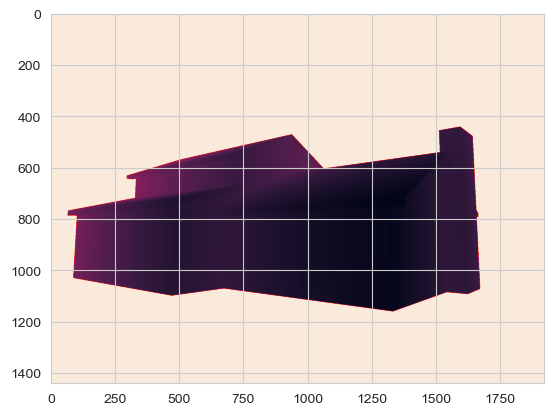

In [414]:
plt.imshow(precomputed_depthmaps[(0, 0)][2])

In [542]:
model = DepthMerger().cuda()
criterion = nn.MSELoss().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


21it [00:05,  4.04it/s]


In [558]:
fill_value = 4000.
shift = 500
losses = []
for epoch in tqdm(range(5)):
    mean_loss = 0
    for k, v in precomputed_depthmaps.items():
        depthmap, pointcloud_deptmap, mesh_depthmap = v
        new_shape = np.array(depthmap.shape) // 2
        depthmap = np.resize(depthmap, new_shape)
        pointcloud_deptmap = np.resize(pointcloud_deptmap, new_shape)
        mesh_depthmap = np.resize(mesh_depthmap, new_shape)
        
        depthmap = (depthmap - shift)  / fill_value
        pointcloud_deptmap = (pointcloud_deptmap - shift) / fill_value
        mesh_depthmap = (mesh_depthmap - shift) / fill_value
        
        depthmap_tensor = torch.tensor(depthmap).unsqueeze(0).unsqueeze(0).float().cuda() 
        pointcloud_deptmap_tensor = torch.tensor(pointcloud_deptmap).unsqueeze(0).unsqueeze(0).float().cuda()
        target = torch.tensor(mesh_depthmap).unsqueeze(0).unsqueeze(0).float().cuda()
        optimizer.zero_grad()
        output = model(depthmap_tensor, pointcloud_deptmap_tensor)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
    print(f"Epoch {epoch}, mean loss {mean_loss/len(precomputed_depthmaps)}")
    losses.append(mean_loss/len(precomputed_depthmaps))
plt.plot(losses)
plt.title("Loss")
plt.show()

  0%|          | 0/5 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for k, v in precomputed_depthmaps.items():
    depthmap, pointcloud_deptmap, mesh_depthmap = v
    plt.imshow(mesh_depthmap)
    plt.show()

0.28975

In [351]:
np.max(projected2d[:,0])

In [318]:
depthmap.shape

In [431]:
print(loss)

In [396]:
output.shape

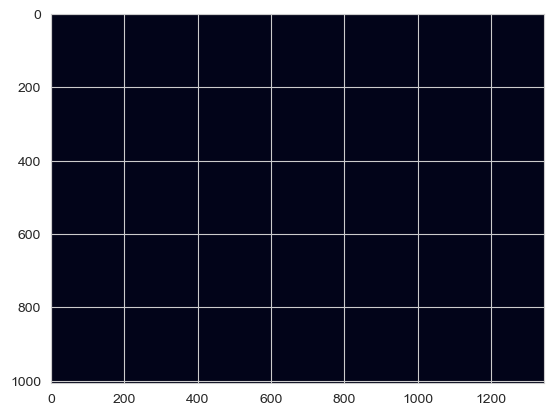

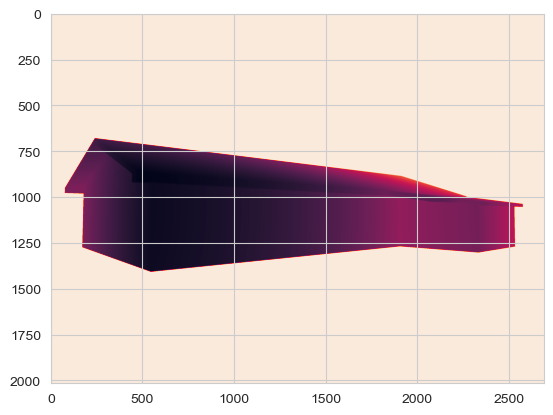

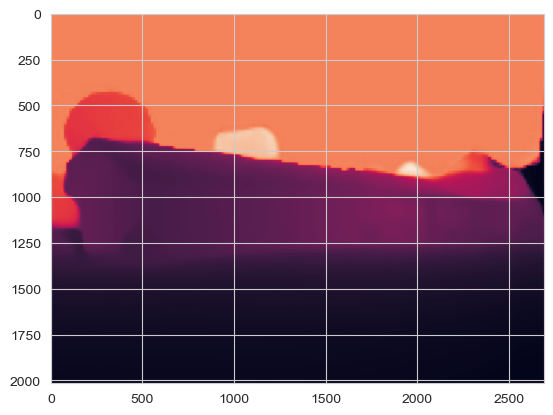

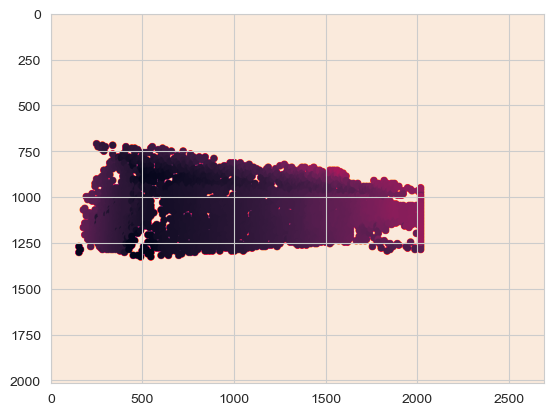

In [559]:
output_np = (output[0][0] * fill_value + shift).cpu().detach().numpy() 
plt.imshow(output_np)
plt.show()
plt.imshow(mesh_depthmap* fill_value + shift)
plt.show()
plt.imshow(depthmap* fill_value + shift)
plt.show()
plt.imshow(pointcloud_deptmap* fill_value + shift)
plt.show()

In [383]:
def get_vetices_3d(depthmap, K,R,t):

    uv = []
    for j in range(depthmap.shape[0]):
        for i in range(depthmap.shape[1]):
            uv.append((i,j))
    uv = np.array(uv)

    depth_vert = depthmap.flatten()
    xy_local = np.ones((len(uv), 3))
    xy_local[:, 0] = (uv[:, 0] - K[0, 2]) / K[0, 0]
    xy_local[:, 1] = (uv[:, 1] - K[1, 2]) / K[1, 1]
    # Get the 3D vertices
    norm_factor = np.linalg.norm(xy_local, axis=1)[..., None]

    norm_factor = np.max(norm_factor)
    # norm_factor = np.mean(norm_factor)
    vertices_3d_local = depth_vert[..., None] * (xy_local / norm_factor)
    world_to_cam = np.eye(4)
    world_to_cam[:3, :3] = R
    world_to_cam[:3, 3] = t
    cam_to_world = np.linalg.inv(world_to_cam)
    vertices_3d = cv2.transform(cv2.convertPointsToHomogeneous(vertices_3d_local), cam_to_world)
    vertices_3d = cv2.convertPointsFromHomogeneous(vertices_3d).reshape(-1, 3)
    # vertices_3d[:,1] = 1
    return vertices_3d, depth_vert

In [420]:
vertices_3d, depth_vert = get_vetices_3d(output_np, K, R, t)

In [421]:
depth_vert

array([1524.9899, 2496.7603, 2488.5474, ..., 1928.4773, 1790.822 ,
       1193.7118], dtype=float32)

In [422]:
scene = trimesh.scene.scene.Scene()
norm = plt.Normalize()
colors = np.array((plt.cm.jet(norm(-depth_vert[::20])) * 255)).astype(np.uint8)
ptcloud = trimesh.points.PointCloud(vertices = vertices_3d[::20], colors=colors)
scene.add_geometry(ptcloud)
pointcloud = trimesh.points.PointCloud(
    vertices=[point3D.xyz for point_id, point3D in sample["points3d"].items()],
    colors=[point3D.rgb for point_id, point3D in sample["points3d"].items()])
scene.add_geometry(pointcloud)
scene.show()